# Airbus Ship Detection

In [71]:
# Import the necessary libraries
import os
import random
import math

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.io import imread
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from skimage.morphology import label
from tqdm import tqdm


# Define the constants
TRAIN_FOLDER = "./airbus_ship_detection/train_v2/"
TEST_FOLDER = "./airbus_ship_detection/test_v2/"
CSV_PATH = "./airbus_ship_detection/train_ship_segmentations_v2.csv"
MODEL_PATH = "./models/model.h5"

IMG_SIZE = (768, 768, 3)
NUM_CLASSES = 2
BATCH_SIZE = 8
MAX_TRAIN_STEPS = 100
VALIDATION_SPLIT = 0.2
NB_EPOCHS = 5
RANDOM_STATE = 42
VAL_IMAGES = 500

# Style the plots and display them inline
plt.style.use("fivethirtyeight")
%matplotlib inline

In [72]:
# Define some helper functions for RLE encoding and decoding, 
# which will be used later for converting 
# the predicted ship masks to the required format

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Convert run-length encoded mask to a binary mask
    
    Args:
        mask_rle (str): Run-length encoded mask string
        shape (tuple): Shape of the output binary mask
    
    Returns:
        numpy.ndarray: Binary mask array
    '''
    # Split the run-length encoded string
    s = mask_rle.split()
    starts = np.asarray(s[0:][::2], dtype=int) - 1
    lengths = np.asarray(s[1:][::2], dtype=int)
    ends = starts + lengths
    
    # Initialize an array for the binary mask
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Set the pixels corresponding to the mask region to 1
    for start, end in zip(starts, ends):
        img[start:end] = 1
    
    # Reshape the array to the desired shape
    return img.reshape(shape).T


def masks_as_image(in_mask_list):
    '''
    Combine individual ship masks into a single mask array
    
    Args:
        in_mask_list (list): List of ship masks (run-length encoded strings)
    
    Returns:
        numpy.ndarray: Combined mask array
    '''
    # Initialize an array to hold the combined mask
    all_masks = np.zeros((768, 768), dtype=np.int16)
    
    # Iterate over the ship masks and add them to the combined mask
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    
    # Expand dimensions to match the expected shape
    return np.expand_dims(all_masks, -1)

In [73]:
# Function to view a random image from the training set
def view_random_image(target_dir):
    '''
    View a random image from the specified directory
    
    Args:
        target_dir (str): Path to the directory containing images
    
    Returns:
        numpy.ndarray: Image array
    '''
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it
    img = mpimg.imread(target_dir + "/" + random_image[0])
    plt.imshow(img)
    plt.axis("off")
    
    # Print the shape of the image
    print(f"Image shape: {img.shape}")
    
    return img


#### How many files do we have?

In [74]:
for dirpath, dirnames, filenames in os.walk("./airbus_ship_detection/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 3 images in './airbus_ship_detection/'.
There are 0 directories and 15606 images in './airbus_ship_detection/test_v2'.
There are 0 directories and 192556 images in './airbus_ship_detection/train_v2'.


#### Observing the dataset

At first, we want to look at our dataset with image IDs and the corresponding masks for the training data.

In [75]:
df = pd.read_csv(CSV_PATH)

In [76]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


#### Checking a single image

Image shape: (768, 768, 3)


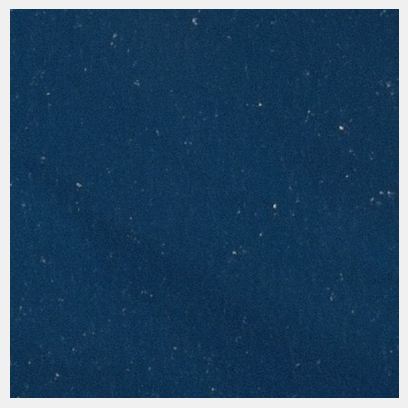

In [77]:
img = view_random_image(TRAIN_FOLDER)

#### How many unique images do we have?

In [78]:
num_images = len(df['ImageId'].unique())
print(f"The number of images in the dataset: {num_images}")

The number of images in the dataset: 192556


#### How many images with ships and non-ships do we have?

In [79]:
num_ships = len(df[df['EncodedPixels'].notna()])
num_non_ships = num_images - num_ships
print('Number of ships:', num_ships)
print('Number of non-ships:', num_non_ships)

Number of ships: 81723
Number of non-ships: 110833


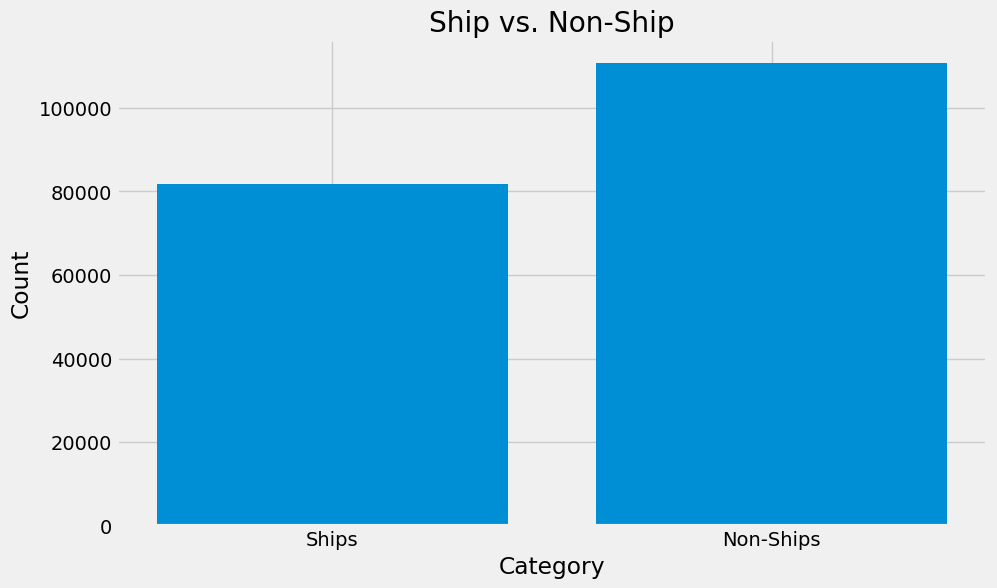

In [80]:
# Plot a bar chart of the ship vs. non-ship distribution
plt.figure(figsize=(10, 6))
plt.bar(['Ships', 'Non-Ships'], [num_ships, num_non_ships])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Ship vs. Non-Ship')
plt.show()

In this dataset, positive and negative samples are highly imbalanced. We will deal with this problem later.

#### What is the distribution of ships on the images?

In [81]:
number_of_masks_counts = df["ImageId"].value_counts()
number_of_masks_counts

ImageId
e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: count, Length: 192556, dtype: int64

In [82]:
# Create a copy of the working datafram
ship_df = df.copy()
ship_df['NumberOfShips'] = ship_df['EncodedPixels'].notnull().astype(int)
ship_df['EncodedPixels'] = ship_df['EncodedPixels'].replace(0, '')
ship_df

,ImageId,EncodedPixels,NumberOfShips
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [83]:
# Group by the image name and sum the number of ships
ship_df = ship_df.groupby('ImageId').sum().reset_index()
ship_df["EncodedPixels"] = ship_df["EncodedPixels"].apply(lambda x: x if x != 0 else "")
ship_df

,ImageId,EncodedPixels,NumberOfShips
0,00003e153.jpg,,0
1,0001124c7.jpg,,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,,0
...,...,...,...
192551,fffedbb6b.jpg,,0
192552,ffff2aa57.jpg,,0
192553,ffff6e525.jpg,,0
192554,ffffc50b4.jpg,,0


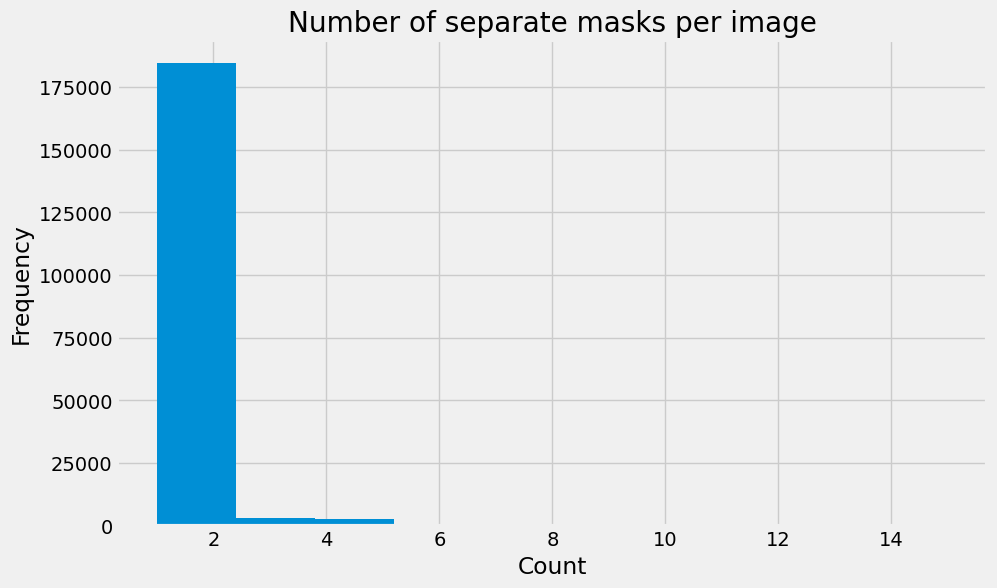

In [84]:
# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(number_of_masks_counts, bins=10)  # Create a histogram with 30 bins
plt.title("Number of separate masks per image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

More than 90% of the images have only one mask. The maximum number of masks for an image is 15.

#### Working with NaNs

Right now we need to do more preprocessing to get the data into a format that we can use for training our model. 


Entries with NaN in the EncodedPixels column are the pictures without any ships.Previously we replaced the NaNs with empty strings in the EncodedPixels column. Let's check if that was correct.

In [85]:
rle_with_zeros = rle_encode(np.zeros((768, 768, 1)))
print(rle_with_zeros == "")

True


Therefore, we can replace all of the NaNs in the EncodedPixels column with an empty string.

In [86]:
df = df.fillna("")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


#### Undersampling negative samples

To make the dataset more balanced, we need to undersample the negative samples as they far outnumber the positive samples. We will randomly select a subset of negative samples to match the number of positive samples.

<Axes: ylabel='Frequency'>

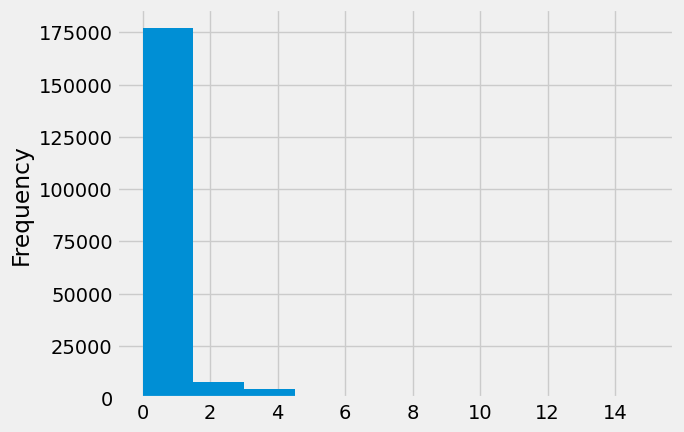

In [87]:
ship_df['NumberOfShips'].plot.hist()

In [88]:
ship_df['NumberOfShips'].value_counts()

NumberOfShips
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

Obviously, we still have a lot of imbalance. Let's create a function to undersample the zero masks.

In [89]:
def undersample_zeros(df):
    zeros = df[df['NumberOfShips'] == 0].sample(n=25_000, random_state = RANDOM_STATE)
    nonzeros = df[df['NumberOfShips'] != 0]
    return pd.concat((nonzeros, zeros))

In [90]:
train_ships, valid_ships = train_test_split(ship_df, 
                 test_size = 0.3, 
                 stratify = ship_df['NumberOfShips'])

<Axes: ylabel='Frequency'>

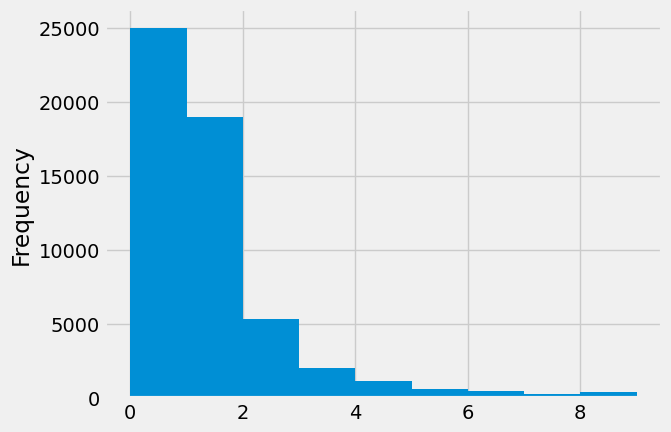

In [91]:
train_ships = undersample_zeros(train_ships)
valid_ships = undersample_zeros(valid_ships)
train_ships['NumberOfShips'].plot.hist(bins=np.arange(10))

<Axes: xlabel='NumberOfShips'>

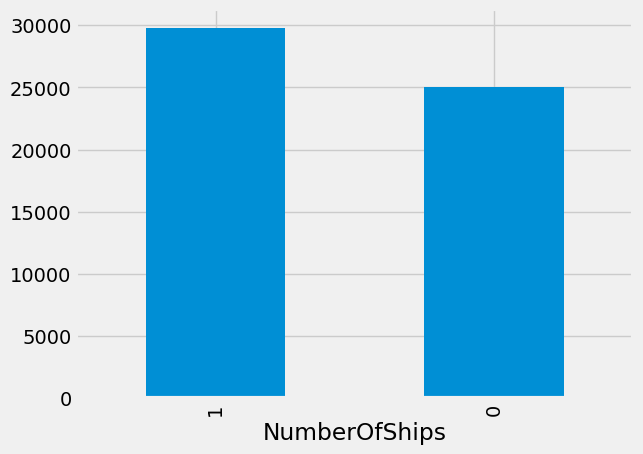

In [92]:
(train_ships['NumberOfShips'] > 0).astype(int).value_counts().plot.bar()

<Axes: xlabel='NumberOfShips'>

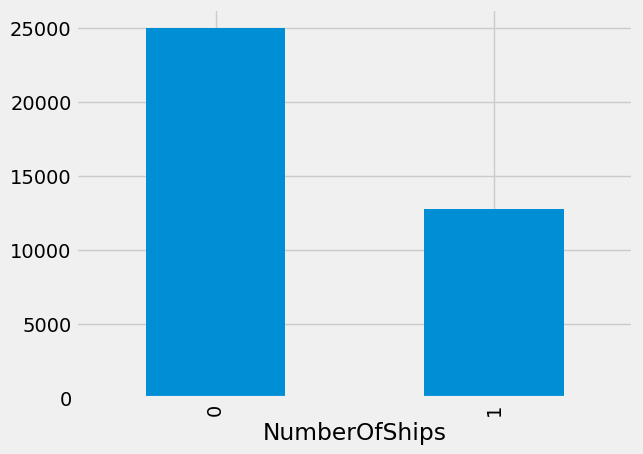

In [93]:
(valid_ships['NumberOfShips'] > 0).astype(int).value_counts().plot.bar()

As we can see, the distribution is much nicer now. We have a more evenly distributed dataset, both for training data and for validation data.

#### Generator for the training data

As our dataset is too large to fit into memory, we need to create a generator to load the data in batches.

In [94]:
class DataGenerator(Sequence):
    def __init__(self, images_set, masks_set, batch_size):
        self.images, self.masks = images_set, masks_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.images) / self.batch_size)

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        return (
                np.array([
                    imread(os.path.join(TRAIN_FOLDER, img_name)) 
                    for img_name in batch_images]), 
                np.array([
                    masks_as_image(self.masks[self.masks['ImageId'] == img_name]['EncodedPixels']) 
                    for img_name in batch_images]))

#### Create a U-Net based model

In [106]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet(input_shape):
    # Input layer
    inputs = Input(input_shape)

    # Contracting path (left side of the U-Net)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U-Net
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expanding path (right side of the U-Net)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv7)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model


# Create the U-Net model
model = unet(IMG_SIZE)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 768, 768, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_55 (Conv2D)          (None, 768, 768, 64)         36928     ['conv2d_54[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 384, 384, 64)         0         ['conv2d_55[0][0]']           
 g2D)                                                                                       

#### Create generators for the training and validation data

In [96]:
train_gen = DataGenerator(np.array(train_ships['ImageId']), df, BATCH_SIZE)
valid_gen = DataGenerator(np.array(valid_ships['ImageId']), df, BATCH_SIZE),

Now, after creating the generators, we can have a look at the images and their corresponding masks. Here, I will take a random sample from the training data and visualize it.

In [97]:
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

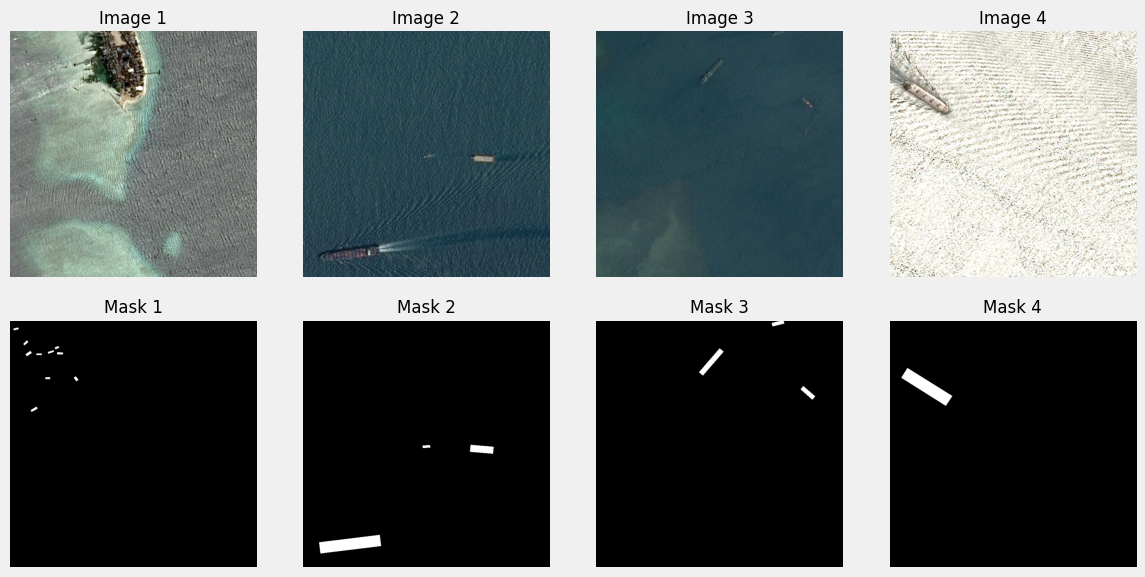

In [98]:
def create_image_mask_montage(images, masks):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, (image, mask, ax) in enumerate(zip(images, masks, axes.T)):
        ax[0].imshow(image)
        ax[0].set_title(f'Image {i + 1}', fontsize=12)
        ax[0].axis('off')

        ax[1].imshow(mask.squeeze(), cmap='gray')
        ax[1].set_title(f'Mask {i + 1}', fontsize=12)
        ax[1].axis('off')

    plt.tight_layout()
    plt.show()

images, masks = train_gen.__getitem__(0)
create_image_mask_montage(images, masks)

#### Compile the model

We will compile the model with the Adam optimizer and binary cross-entropy loss. Also, to monitor the pregresss, we will introduce a couple of custom metrics.

In [99]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    # Reshape the true masks
    y_true = K.cast(y_true, 'float32')
    # Calculate the intersection between predicted and true masks
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    # Calculate the union of predicted and true masks
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    # Calculate the Dice coefficient
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    # Combine binary cross-entropy and negative Dice coefficient
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    # Calculate the true positive rate
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

def precision(y_true, y_pred):
    # Calculate the precision rate (the proportion of true positive predictions
    # out of all positive predictions)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    # Calculate the recall rate (the proportion of true positive predictions 
    # out of all positive samples)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def specificity(y_true, y_pred):
    # Calculate the specificity rate (the proportion of true negative 
    # predictions out of all negative samples)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    # Calculate the F1 score (harmonic mean of precision and recall)
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


# Compile the model with the Adam optimizer,
# binary cross-entropy and the custom metrics
model.compile(optimizer="adam", 
              loss=dice_p_bce, 
              metrics=[dice_coef, 
                       'binary_accuracy', 
                       true_positive_rate, 
                       precision, 
                       recall, 
                       specificity, 
                       f1_score])

#### Creating callbacks for the model

Here we create a callback to save the model weights after each epoch. We will use these weights later to make predictions on the test set. Also, we will create additional callbacks to monitor the training process.

In [100]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Path to save intermediate and model weights
weight_path="{}_weights.best.hdf5".format('seg_model')

# Save the model after each epoch if the validation loss improved
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

# Reduce the learning rate when the metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

# Stop training when the validation loss has stopped improving
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15)

# Keep track of training history by creating a callbacks list
callbacks_list = [checkpoint, early, reduceLROnPlat]

#### Train the model

In order to train the model, we will use keras.fit method with the generators we created earlier. It took a lot of time for a model to train (it reached the end of the training only once throughout the development process), so I decided to comment the training part. However, it can be accessed through the ```train.py``` file.

In [101]:
# history = model.fit(train_gen,
#                     validation_data=valid_gen, 
#                     epochs=NB_EPOCHS, 
#                     callbacks=callbacks_list)
print("Training the model...")

Training the model...


In [102]:
# model.load_weights(weight_path)
# model.save('models/model.h5')

#### Load the model and the test data

In [103]:
# model = models.load_model(MODEL_PATH, compile=False)

In [104]:
# test_paths = os.listdir(TEST_FOLDER)

# out_pred_rows = []
# for img_id in test_paths:
#     img = imread(os.path.join(TEST_FOLDER, img_id))
#     img = np.expand_dims(img, 0)/255.0
#     prediction = model.predict(img)[0]
#     encodings = multi_rle_encode(prediction)
#     # Add an entry with None if there is no ship detected and 
#     out_pred_rows.append([{'ImageId': img_id, 'EncodedPixels': encoding} 
#                       if encodings 
#                       else {'ImageId': img_id, 'EncodedPixels': None} 
#                       for encoding in encodings])

In [105]:
# result_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
# result_df.to_csv('result.csv', index=False)